In [1]:
import numpy as np
import scipy.special as ssp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD

pyro.enable_validation(True)
torch.set_default_dtype(torch.double)  # this was necessary on the CPU

In [9]:
def build_logistic_dataset(N, p=1, noise_std=0.01):
    X = np.random.randn(N, p)

    w = np.random.randn(p)
    w += 2 * np.sign(w)

    y = np.round(
        ssp.expit(
            np.matmul(X, w) + np.repeat(1, N) + np.random.normal(0, noise_std, size=N)
        )
    )
    y = y.reshape(N, 1)
    return X, y, w

In [10]:
build_logistic_dataset(40)[2]

array([-2.83731422])

In [ ]:
1

In [11]:
# these were adapted from the Pyro VAE tutorial


def train(svi, train_loader, n_train):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, xs in enumerate(train_loader):
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(*xs)

    # return epoch loss
    total_epoch_loss_train = epoch_loss / n_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, n_test):
    # initialize loss accumulator
    test_loss = 0.0
    # compute the loss over the entire test set
    for _, xs in enumerate(test_loader):
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(*xs)

    total_epoch_loss_test = test_loss / n_test
    return total_epoch_loss_test


def plot_llk(train_elbo, test_elbo, test_int):
    plt.figure(figsize=(8, 6))

    x = np.arange(len(train_elbo))

    plt.plot(x, train_elbo, marker="o", label="Train ELBO")
    plt.plot(x[::test_int], test_elbo, marker="o", label="Test ELBO")
    plt.xlabel("Training Epoch")
    plt.legend()
    plt.show()

In [12]:
class LogRegressionModel(nn.Module):
    def __init__(self, p):
        super(LogRegressionModel, self).__init__()

        self.p = p

        # hyperparameters for normal priors
        self.alpha_h_loc = torch.zeros(1, p)
        self.alpha_h_scale = 10.0 * torch.ones(1, p)
        self.beta_h_loc = torch.zeros(1)
        self.beta_h_scale = 10.0 * torch.ones(1)

        # initial values of variational parameters
        self.alpha_0 = np.zeros((1, p))
        self.alpha_0_scale = np.ones((1, p))
        self.beta_0 = np.zeros((1,))
        self.beta_0_scale = np.ones((1,))

    def model(self, x, y):
        # sample from prior
        a = pyro.sample(
            "weight",
            dist.Normal(
                self.alpha_h_loc, self.alpha_h_scale, validate_args=True
            ).independent(1),
        )
        b = pyro.sample(
            "bias",
            dist.Normal(
                self.beta_h_loc, self.beta_h_scale, validate_args=True
            ).independent(1),
        )

        with pyro.iarange("data", x.size(0)):
            model_logits = (torch.matmul(x, a.permute(1, 0)) + b).squeeze()

            pyro.sample(
                "obs",
                dist.Bernoulli(logits=model_logits, validate_args=True),
                obs=y.squeeze(),
            )

    def guide(self, x, y):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param(
            "alpha_scale",
            torch.tensor(self.alpha_0_scale),
            constraint=constraints.positive,
        )
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param(
            "beta_scale",
            torch.tensor(self.beta_0_scale),
            constraint=constraints.positive,
        )

        pyro.sample(
            "weight",
            dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1),
        )
        pyro.sample(
            "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
        )

In [13]:
pyro.clear_param_store()

optim = Adam({"lr": 0.01})

num_epochs = 1000
batch_size = 50

N = 1000
p = 3

X, y, w = build_logistic_dataset(N, p)

example_indices = np.random.permutation(N)
n_train = int(0.9 * N)  # 90%/10% train/test split
n_test = N - n_train
test_iter = 50

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [16]:
lr_model = LogRegressionModel(p=p)

svi = SVI(lr_model.model, lr_model.guide, optim, loss=Trace_ELBO())


lr_dataset = torch.utils.data.TensorDataset(X, y)

data_loader_train = DataLoader(
    dataset=lr_dataset,
    batch_size=batch_size,
    pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[:n_train]),
)

data_loader_test = DataLoader(
    dataset=lr_dataset,
    batch_size=batch_size,
    pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[n_train:]),
)

train_elbo = []
test_elbo = []
for epoch in range(num_epochs):
    total_epoch_loss_train = train(svi, data_loader_train, n_train)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % test_iter == 0:
        print(
            "[epoch %03d]  average training loss: %.4f"
            % (epoch, total_epoch_loss_train)
        )
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loader_test, n_test)
        test_elbo.append(-total_epoch_loss_test)

[epoch 000]  average training loss: 1.0830
[epoch 050]  average training loss: 0.3562
[epoch 100]  average training loss: 0.2939
[epoch 150]  average training loss: 0.2802
[epoch 200]  average training loss: 0.2903
[epoch 250]  average training loss: 0.2455
[epoch 300]  average training loss: 0.2703
[epoch 350]  average training loss: 0.2564
[epoch 400]  average training loss: 0.2579
[epoch 450]  average training loss: 0.2281
[epoch 500]  average training loss: 0.2496
[epoch 550]  average training loss: 0.2372
[epoch 600]  average training loss: 0.2480
[epoch 650]  average training loss: 0.2302
[epoch 700]  average training loss: 0.2379
[epoch 750]  average training loss: 0.2300
[epoch 800]  average training loss: 0.2568
[epoch 850]  average training loss: 0.2584
[epoch 900]  average training loss: 0.2442
[epoch 950]  average training loss: 0.2406


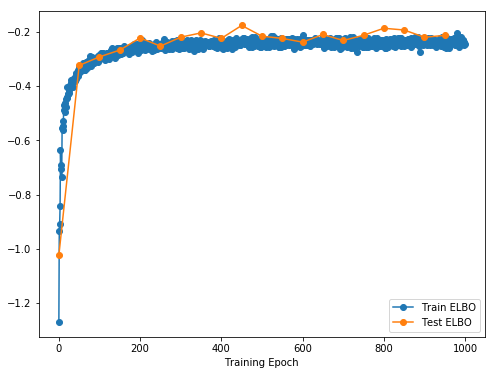

In [7]:
plot_llk(train_elbo, test_elbo, test_iter)